In [1]:
#/bin/python
import sys
import os
import numpy as np
sys.path.append('..')
from src import NeuralNet
from src import train as fit
from src import make_directory 
from models import load_model
from data import load_data
from six.moves import cPickle
np.random.seed(247) # for reproducibility
import theano
import theano.tensor as T
from lasagne import layers, objectives, updates, regularization
import matplotlib.pyplot as plt
%matplotlib inline


Using gpu device 0: GeForce GTX 980 (CNMeM is disabled, CuDNN 4007)


In [2]:
name = 'MotifSimulation_correlated'
datapath = '/home/peter/Data/SequenceMotif'
filepath = os.path.join(datapath, 'synthetic_correlated_motifs_100000.hdf5')

In [110]:
train, valid, test = load_data(name, filepath)
shape = (None, train[0].shape[1], train[0].shape[2], train[0].shape[3])
num_labels = np.round(train[1].shape[1])

# calculate correlations
labels = np.vstack([train[1], valid[1]])
N = labels.shape[0]
rho = np.zeros((num_labels, num_labels))
for i in range(num_labels):
    p_i = np.sum(labels[:,i])/N
    for j in range(i):
        p_j = np.sum(labels[:,j])/N    
        p_ij = np.sum(labels[:,i]*labels[:,j])/N
        norm = np.sqrt(p_i*(1-p_i)) * np.sqrt(p_j*(1-p_j))
        rho[j,i] = (p_ij - p_i*p_j)/norm
f = open('/home/peter/Code/Deepomics/examples/rho.pickle','wb')
cPickle.dump(rho, f)
f.close()


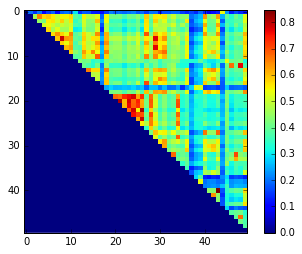

In [111]:

plt.imshow(rho, interpolation='none')
plt.colorbar()

In [80]:
model_name = "binary_genome_motif_model"
network, input_var, target_var, optimization = load_model(model_name, shape, num_labels)

In [107]:
# build loss function
prediction = layers.get_output(network['output'], deterministic=False)
prediction = T.clip(prediction, 1e-7, 1-1e-7)
loss1 = -(target_var*T.log(prediction) + (1.0-target_var)*T.log(1.0-prediction))    
u = T.abs_(target_var - prediction)/T.sqrt(prediction*(1-prediction))
diag = T.diag(T.dot(optimization["rho"], u.T).dot(u))
loss = loss1 + T.log(1+T.sum(diag[1:])/prediction.shape[0])

# calculate and clip gradients
params = layers.get_all_params(network['output'], trainable=True)    
grad = T.grad(loss.mean(), params)

# setup parameter updates
update_op = updates.adam(grad, params, 
                        learning_rate=optimization['learning_rate'], 
                        beta1=optimization['beta1'], 
                        beta2=optimization['beta2'], 
                        epsilon=optimization['epsilon'])

# create theano function
train_fun = theano.function([input_var, target_var], [loss, prediction, diag, u, loss1], updates=update_op)


In [108]:
def batch_generator(X, y, batch_size=128, shuffle=True):
    """python generator to get a randomized minibatch"""
    """
    while True:
        idx = np.random.choice(len(y), N)
        yield X[idx].astype('float32'), y[idx].astype('int32')
    """
    if shuffle:
        indices = np.arange(len(X))
        np.random.shuffle(indices)
    for start_idx in range(0, len(X)-batch_size+1, batch_size):
        if shuffle:
            excerpt = indices[start_idx:start_idx+batch_size]
        else:
            excerpt = slice(start_idx, start_idx+batch_size)
        yield X[excerpt], y[excerpt]
        
batch_size = 100
num_batches = train[0].shape[0] // batch_size
batches = batch_generator(train[0], train[1], batch_size)
value = 0
    

In [109]:
for i in range(num_batches):
    X, y = next(batches)
    loss, prediction, diag, u, loss1 = train_fun(X, y)
    print loss.mean()

8.02141300173
8.53242705845
7.54978901715
7.12852073107
6.77569772204
6.49837039204
6.4494918448
6.37064693869
6.19371280195
6.09737128063
6.01132766072
6.03536843837
5.97349479105
6.39954173968
6.17951781448
6.14750544184
6.69762183131
6.16946580737
5.85910625676
5.90848836108
6.02353997973
6.14211114535
6.15260898617
6.07029464881
5.96500482315
5.89553095882
5.83672663929
6.04690018601
6.17032943062
5.94792945702
5.84522112057
5.94244743065
5.98294020328
5.72416396095
6.03848592725
5.68211383768
5.82815543821
5.78097482753
5.69811396229
5.68787035429
5.93533598111
6.18871391537
5.95284417502
5.75961951951
5.79128918062
6.0135649701
6.04694750571
5.76830436429
5.78430248807
5.8794365918
5.68747025831
5.9007782225
5.96908071272
5.81659020839
5.91490226263
5.83262013972
5.86753456693
5.66601266076
5.92308459749
6.04341745573
5.85976067577
5.76777590331
5.82479588076
5.67031150883
5.88824872084
5.79017203231
5.80351581089
5.81809287793
5.79807363765
5.91010343296
5.8745886867
5.789015598

KeyboardInterrupt: 

In [55]:
loss = -(y*np.log(prediction) + (1.0-y)*np.log(1.0-prediction))
prediction = np.clip(prediction, 1e-7, 1-1e-7)
u = (y - prediction)/np.sqrt(prediction*(1-prediction))
diag = np.diag(np.dot(optimization["rho"], u.T).dot(u))
loss += np.log(1+np.sum(diag[1:]))
loss.mean()

nan

In [78]:
u

array([[ 2068.3654886 ,   537.72488747,  1248.90502485, ...,
         2368.78781313,  2728.24371525,  2269.83789565],
       [-2544.40966355,  1973.05147464,   233.51594094, ...,
         2765.0460706 ,  2440.04907186,  2412.70345843],
       [-1742.09783769, -1410.89666656, -1261.25881038, ...,
        -2288.82084409, -1102.62623085,  1681.19265475],
       ..., 
       [  126.77392314, -1211.24533121,  2593.41163324, ...,
         2202.6971391 ,  1917.89167047, -2099.40473326],
       [ 2330.10153577,  1757.51496301,  2961.24707724, ...,
         -112.54254195,  1788.63388659,  1295.73891153],
       [ -538.91569944, -2323.72651814, -1035.16382049, ...,
         -537.26963901, -1605.17020939, -2194.48720916]])

In [69]:
-(y*np.log(prediction) + (1.0-y)*np.log(1.0-prediction))

array([[ 0.71801245,  1.43099165,  0.21702613, ...,  0.30910468,
         1.04342985,  2.22963452],
       [ 1.00474834,  0.4768689 ,  1.79354262, ...,  0.54428101,
         0.916255  ,  0.19549783],
       [ 0.09007996,  1.13494444,  0.14259155, ...,  0.06944793,
         0.37367162,  2.6532383 ],
       ..., 
       [ 0.46270326,  1.51770461,  1.12974608, ...,  1.40639508,
         1.75568771,  0.7714783 ],
       [ 0.60144478,  0.99455178,  1.05356121, ...,  0.2294945 ,
         1.64392853,  0.9570955 ],
       [ 0.75623971,  0.127327  ,  0.25774029, ...,  0.2504077 ,
         2.66497374,  1.57627904]], dtype=float32)